In [130]:
import numpy as np
import preprocessing as pp

from graph import *
from bayesian_decision_evaluation import *
# import importlib
from models.gmm_clf import GMM
from models.logistic_regression_classifier import LogisticRegression, LogisticRegressionWeighted, QuadraticExpansion
from models.svm_classifier import SVMClassifier
from models.svm_kernel_classifier import SVMClassifierPolyKernel, SVMClassifierRBFKernel
from models.multivariate_gaussian_classifier import MultivariateGaussianClassifier, NaiveBayesClassifier, TiedCovarianceClassifier

In [131]:
X, y = utils.load_data()
X_eval, y_eval = utils.load_validation_data()
classes = {
    'Fake': 'blue',
    'Real': 'orange'
}

X_train, y_train, X_test, y_test = utils.split_data(X, y)

In [132]:
def compute_statistics(llr, y_true, prior, unique_labels=None, graph=False):
    cost_matrix, prior_class_prob, threshold = binary_cost_matrix(prior)
    
    min_DCF, best_threshold = compute_minDCF(llr, y_true, prior, unique_labels)
    y_pred = (llr > threshold) * 1
    y_pred_best = (llr > best_threshold) * 1
    cm = confusion_matrix(y_true, y_pred, unique_labels)
    cm_best = confusion_matrix(y_true, y_pred_best, unique_labels)
    acc_best = accuracy(cm_best)
    acc = accuracy(cm)
    DCF, _, _ = compute_DCF(cm, cost_matrix, prior_class_prob)
    DCF_norm, _, _ = compute_DCF_normalized(cm, cost_matrix, prior_class_prob)
    
    print(f"MinDCF: {min_DCF:.4f}, DCF: {DCF:.4f}, Normalized DCF: {DCF_norm:.4f}, Accuracy: {acc*100:.2f}%\n")
    if graph:
        plot_bayes_error(llr, y_true, unique_labels)

In [133]:
test_only = True

#### Comparison with Calibration

#### Best model for GMM: GMM - diagonal 8 components

In [134]:
covariance_type = 'diagonal'
n_best_components = 8
prior = 0.1
psiEig = 0.01

model = GMM(n_components=n_best_components, covariance_type=covariance_type, psiEig=psiEig)
folder = f"gmm_{covariance_type}_{n_best_components}_components"
model.fit(X_train, y_train, n_features=2, folder=folder, test_only=test_only)
gmm_score = model.score_binary(X_test)
compute_statistics(gmm_score, y_test, prior, unique_labels=[0, 1])

GMM 0 loaded successfully.
GMM 1 loaded successfully.
MinDCF: 0.1463, DCF: 0.0181, Normalized DCF: 0.1809, Accuracy: 93.85%



#### Best model for SVM: SVM - RBF with gamma = 0.1, epsilon = 1.0, C = 100.0

In [135]:
eps = 1.0
gamma = 1e-1
C = 100.0
prior = 0.1

model = SVMClassifierRBFKernel(C=C, gamma=gamma, eps=eps)
folder = f"svm_rbf_raw_data_gamma_{gamma:.1e}_eps_{eps}_C_{C:.1e}".replace('.', '_').replace('e-0', 'e-')
model.fit(X_train, y_train, folder, test_only)
svm_score = model.score(X_test)
compute_statistics(svm_score, y_test, prior, unique_labels=[0, 1])

Model loaded successfully.
MinDCF: 0.1845, DCF: 0.0358, Normalized DCF: 0.3581, Accuracy: 93.55%



#### Best model for Logistic Regression: Quadratic Expansion with lambda = 0.032, pi = 0.1

In [136]:
l = 0.032
prior = 0.1
n_T = np.sum(y_train == 1)
n_F = np.sum(y_train == 0)
pEmp = n_T / (n_T + n_F)

model = QuadraticExpansion(lambda_=l)
X_train_quad = model.expand(X_train)
X_test_quad = model.expand(X_test)
folder = f"lr_quad_raw_data_pi_{prior:.1e}_lambda_{l:.1e}".replace('.', '_').replace('e-0', 'e-')
model.fit(X_train_quad, y_train, folder=folder, test_only=test_only)
lr_score = model.score(X_test_quad) - np.log(pEmp / (1 - pEmp))
compute_statistics(lr_score, y_test, prior, unique_labels=[0, 1])

Weights loaded successfully.
MinDCF: 0.2436, DCF: 0.0497, Normalized DCF: 0.4972, Accuracy: 89.35%



#### K-Fold Calibration

In [137]:
k_fold = 10
prior_calibration = 0.2

In [138]:
def extract_fold(X, idx):
    return np.hstack([X[jdx::k_fold] for jdx in range(k_fold) if jdx != idx]), X[idx::k_fold]

In [139]:
def calibrate_system(score_s1, labels, prior):
    calibrated_scores = []
    calibrated_labels = []
    for i in range(k_fold):
        score_cal, score_val = extract_fold(score_s1, i)
        labels_cal, labels_val = extract_fold(labels, i)
        
        clf = LogisticRegressionWeighted(lambda_=0, pi=prior, n_T=np.sum(labels_cal==1), n_F=np.sum(labels_cal==0))
        # print(f"\t\tCalibration fold {i + 1}\n")
        clf.fit(score_cal.reshape(1, -1), labels_cal)
        calibrated_sval = clf.score(score_val.reshape(1, -1)) - np.log(prior / (1 - prior))
        calibrated_scores.append(calibrated_sval)
        calibrated_labels.append(labels_val)
    
    calibrated_scores = np.hstack(calibrated_scores)
    calibrated_labels = np.hstack(calibrated_labels)

    return calibrated_scores, calibrated_labels

In [140]:
gmm_calibrated_scores, gmm_calibrated_labels = calibrate_system(gmm_score, y_test, prior_calibration)
svm_calibrated_scores, svm_calibrated_labels = calibrate_system(svm_score, y_test, prior_calibration)
lr_calibrated_scores, lr_calibrated_labels = calibrate_system(lr_score, y_test, prior_calibration)

In [141]:
clf_cal_gmm = LogisticRegressionWeighted(lambda_=0, pi=prior_calibration, n_T=np.sum(gmm_calibrated_labels==1), n_F=np.sum(gmm_calibrated_labels==0))
clf_cal_svm = LogisticRegressionWeighted(lambda_=0, pi=prior_calibration, n_T=np.sum(svm_calibrated_labels==1), n_F=np.sum(svm_calibrated_labels==0))
clf_cal_lr = LogisticRegressionWeighted(lambda_=0, pi=prior_calibration, n_T=np.sum(lr_calibrated_labels==1), n_F=np.sum(lr_calibrated_labels==0))

In [142]:
clf_cal_gmm.fit(gmm_score.reshape(1, -1), y_test)
clf_cal_svm.fit(svm_score.reshape(1, -1), y_test)
clf_cal_lr.fit(lr_score.reshape(1, -1), y_test)

GMM with prior 0.1
MinDCF: 0.1463, DCF: 0.0181, Normalized DCF: 0.1809, Accuracy: 93.85%



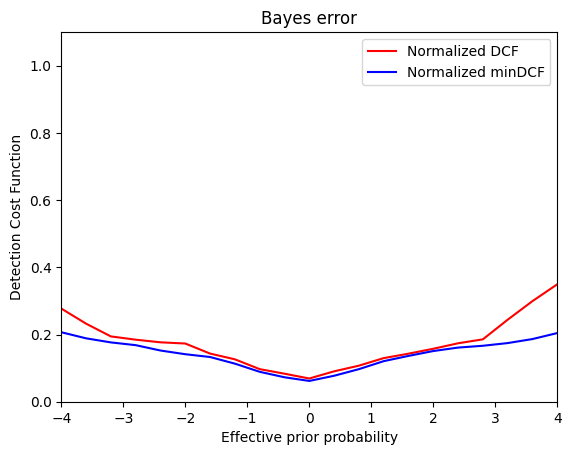

In [143]:
print(f"GMM with prior {prior}")
compute_statistics(gmm_score, y_test, prior, unique_labels=[0, 1], graph=True)

GMM calibrated with prior 0.1
MinDCF: 0.1552, DCF: 0.0179, Normalized DCF: 0.1787, Accuracy: 93.40%



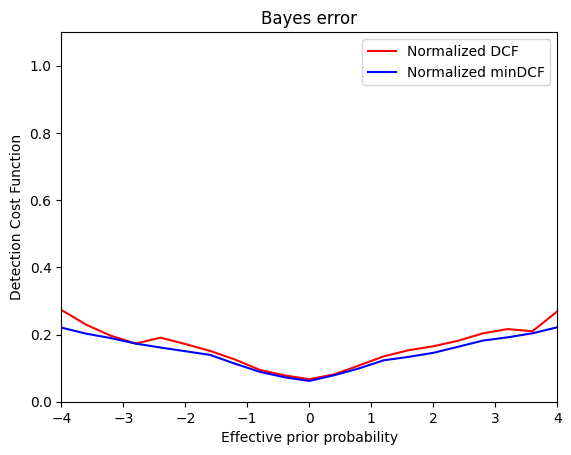

In [144]:
print(f"GMM calibrated with prior {prior}")
compute_statistics(gmm_calibrated_scores, gmm_calibrated_labels, prior, unique_labels=[0, 1], graph=True)

SVM with prior 0.1
MinDCF: 0.1845, DCF: 0.0358, Normalized DCF: 0.3581, Accuracy: 93.55%



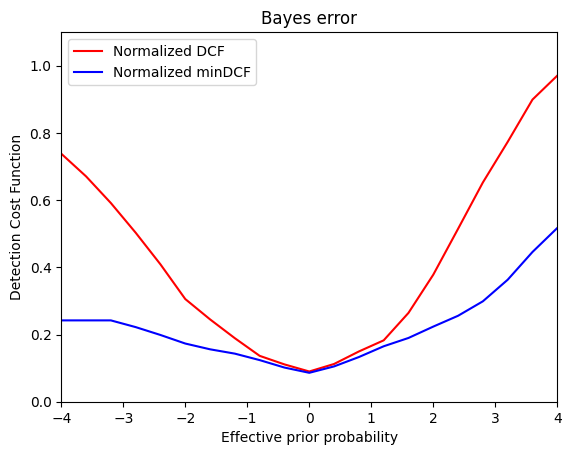

In [145]:
print(f"SVM with prior {prior}")
compute_statistics(svm_score, y_test, prior, unique_labels=[0, 1], graph=True)

SVM calibrated with prior 0.1
MinDCF: 0.1884, DCF: 0.0195, Normalized DCF: 0.1953, Accuracy: 92.95%



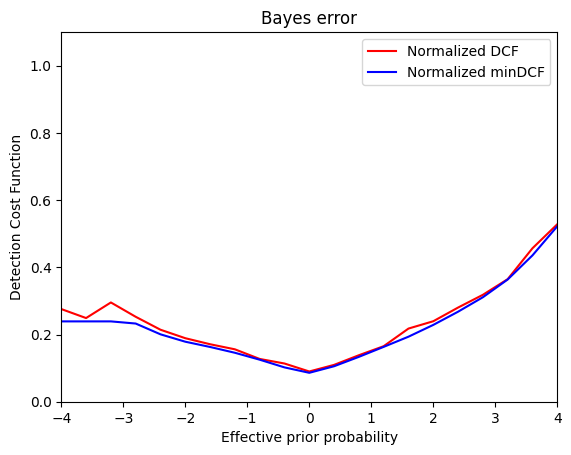

In [146]:
print(f"SVM calibrated with prior {prior}")
compute_statistics(svm_calibrated_scores, svm_calibrated_labels, prior, unique_labels=[0, 1], graph=True)

LR with prior 0.1
MinDCF: 0.2436, DCF: 0.0497, Normalized DCF: 0.4972, Accuracy: 89.35%



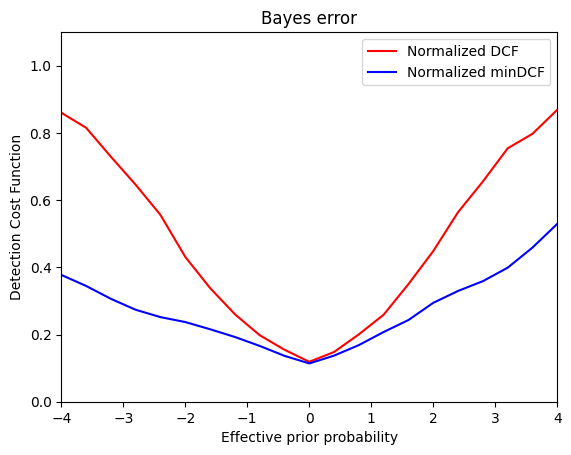

In [147]:
print(f"LR with prior {prior}")
compute_statistics(lr_score, y_test, prior, unique_labels=[0, 1], graph=True)

LR calibrated with prior 0.1
MinDCF: 0.2476, DCF: 0.0267, Normalized DCF: 0.2670, Accuracy: 89.15%



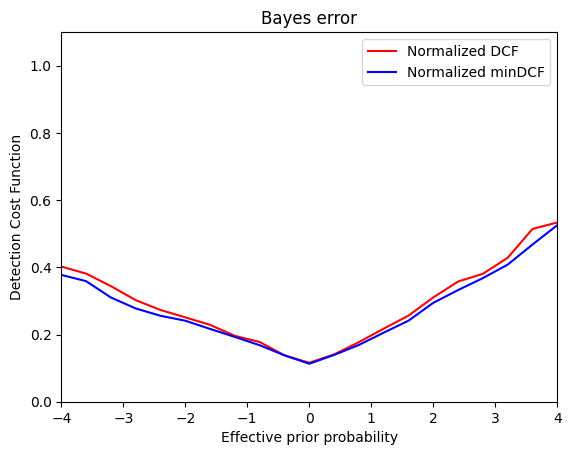

In [148]:
print(f"LR calibrated with prior {prior}")
compute_statistics(lr_calibrated_scores, lr_calibrated_labels, prior, unique_labels=[0, 1], graph=True)

#### Fusion of GMM, SVM and Logistic Regression

In [149]:
fused_scores = []
fused_labels = []

for idx in range(k_fold):
    gmm_cal, gmm_val = extract_fold(gmm_score, idx)
    svm_cal, svm_val = extract_fold(svm_score, idx)
    lr_cal, lr_val = extract_fold(lr_score, idx)
    labels_cal, labels_val = extract_fold(y_test, idx)
    
    score_cal = np.vstack([gmm_cal, svm_cal, lr_cal])
    score_val = np.vstack([gmm_val, svm_val, lr_val])
    
    clf_fusion = LogisticRegressionWeighted(lambda_=0, pi=prior_calibration, n_T=np.sum(labels_cal==1), n_F=np.sum(labels_cal==0))
    clf_fusion.fit(score_cal, labels_cal)
    fused_score = clf_fusion.score(score_val) - np.log(prior_calibration / (1 - prior_calibration))
    fused_scores.append(fused_score)
    fused_labels.append(labels_val)

fused_scores = np.hstack(fused_scores)
fused_labels = np.hstack(fused_labels)

Fusion with prior 0.1
MinDCF: 0.1582, DCF: 0.0170, Normalized DCF: 0.1697, Accuracy: 93.25%



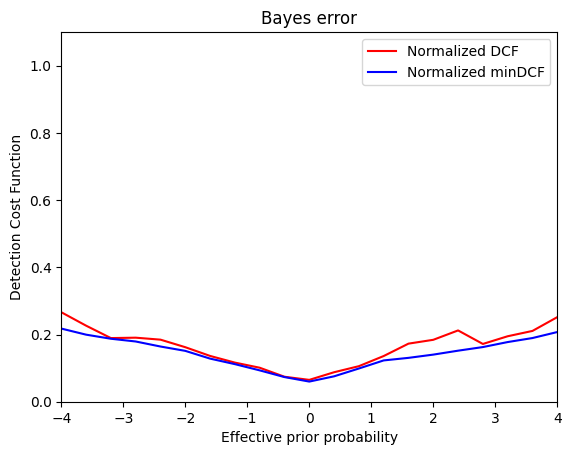

In [150]:
print(f"Fusion with prior {prior}")
compute_statistics(fused_scores, fused_labels, prior, unique_labels=[0, 1], graph=True)

#### Validation
Chosen model: GMM - diagonal 8 components

In [151]:
covariance_type = 'diagonal'
n_best_components = 8
prior = 0.1
psiEig = 0.01

model = GMM(n_components=n_best_components, covariance_type=covariance_type, psiEig=psiEig)
folder = f"gmm_{covariance_type}_{n_best_components}_components"
model.fit(X_train, y_train, n_features=2, folder=folder, test_only=test_only)
gmm_score_eval = model.score_binary(X_eval)

GMM 0 loaded successfully.
GMM 1 loaded successfully.


In [152]:
gmm_score_eval_calibrated = clf_cal_gmm.score(gmm_score_eval.reshape(1, -1)) - np.log(prior_calibration / (1 - prior_calibration))

GMM evaluation set with prior 0.1
MinDCF: 0.2026, DCF: 0.0221, Normalized DCF: 0.2209, Accuracy: 92.82%



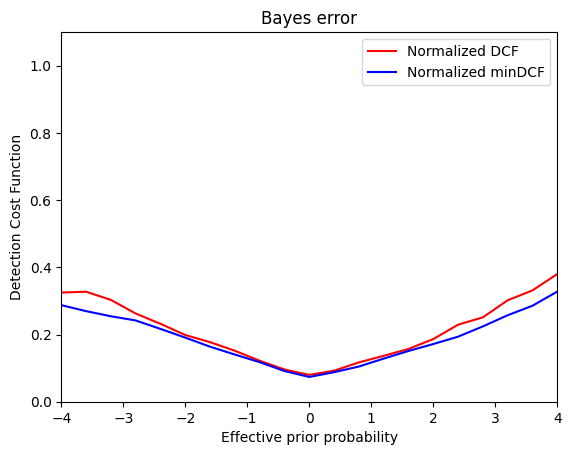

In [153]:
print(f"GMM evaluation set with prior {prior}")
compute_statistics(gmm_score_eval, y_eval, prior, unique_labels=[0, 1], graph=True)

GMM evaluation set calibrated with prior 0.1
MinDCF: 0.2026, DCF: 0.0218, Normalized DCF: 0.2183, Accuracy: 92.82%



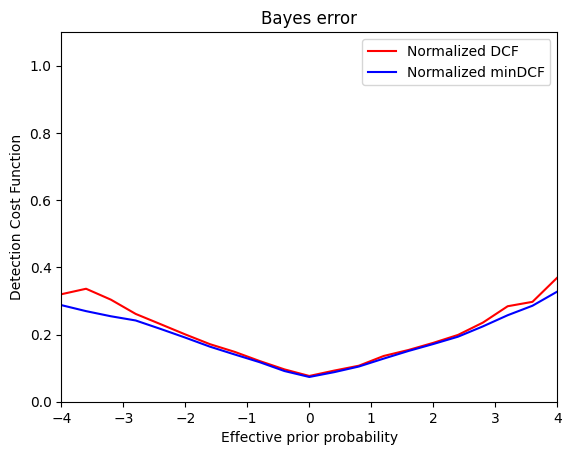

In [154]:
print(f"GMM evaluation set calibrated with prior {prior}")
compute_statistics(gmm_score_eval_calibrated, y_eval, prior, unique_labels=[0, 1], graph=True)

#### Evaluate the other models

In [155]:
eps = 1.0
gamma = 1e-1
C = 100.0
prior = 0.1

model = SVMClassifierRBFKernel(C=C, gamma=gamma, eps=eps)
folder = f"svm_rbf_raw_data_gamma_{gamma:.1e}_eps_{eps}_C_{C:.1e}".replace('.', '_').replace('e-0', 'e-')
model.fit(X_train, y_train, folder, test_only)
svm_score_eval = model.score(X_eval)

Model loaded successfully.


In [156]:
svm_score_eval_calibrated = clf_cal_svm.score(svm_score_eval.reshape(1, -1)) - np.log(prior_calibration / (1 - prior_calibration))

SVM evaluation set with prior 0.1
MinDCF: 0.2636, DCF: 0.0363, Normalized DCF: 0.3634, Accuracy: 90.97%



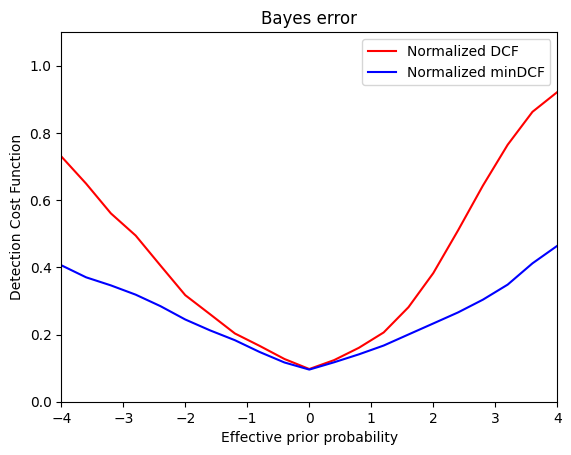

In [157]:
print(f"SVM evaluation set with prior {prior}")
compute_statistics(svm_score_eval, y_eval, prior, unique_labels=[0, 1], graph=True)

SVM evaluation set calibrated with prior 0.1
MinDCF: 0.2636, DCF: 0.0284, Normalized DCF: 0.2843, Accuracy: 90.97%



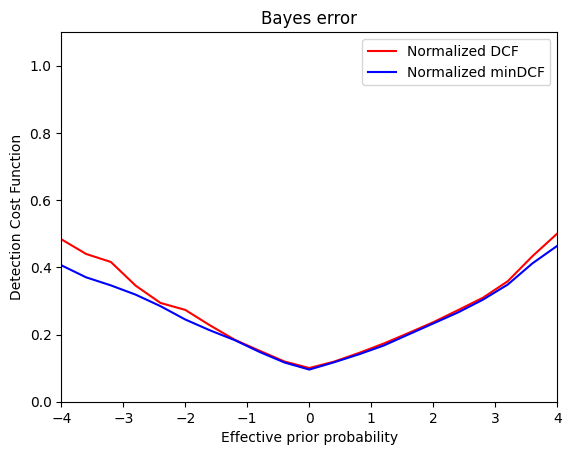

In [158]:
print(f"SVM evaluation set calibrated with prior {prior}")
compute_statistics(svm_score_eval_calibrated, y_eval, prior, unique_labels=[0, 1], graph=True)

In [159]:
l = 0.032
prior = 0.1
n_T = np.sum(y_train == 1)
n_F = np.sum(y_train == 0)
pEmp = n_T / (n_T + n_F)

model = QuadraticExpansion(lambda_=l)
X_train_quad = model.expand(X_train)
X_eval_quad = model.expand(X_eval)
folder = f"lr_quad_raw_data_pi_{prior:.1e}_lambda_{l:.1e}".replace('.', '_').replace('e-0', 'e-')
model.fit(X_train_quad, y_train, folder=folder, test_only=test_only)
lr_score_eval = model.score(X_eval_quad) - np.log(pEmp / (1 - pEmp))

Weights loaded successfully.


In [160]:
lr_score_eval_calibrated = clf_cal_lr.score(lr_score_eval.reshape(1, -1)) - np.log(prior_calibration / (1 - prior_calibration))

LR evaluation set with prior 0.1
MinDCF: 0.3515, DCF: 0.0494, Normalized DCF: 0.4942, Accuracy: 87.12%



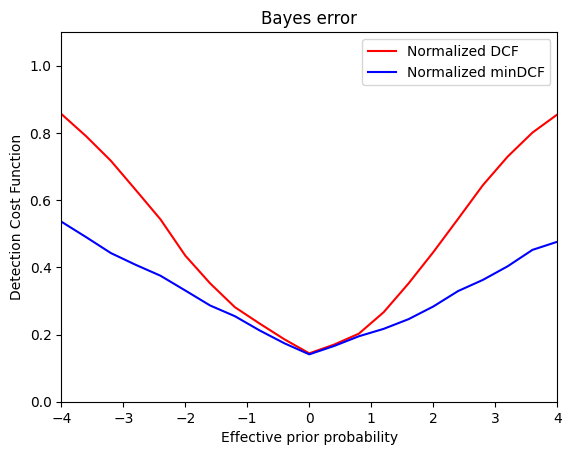

In [161]:
print(f"LR evaluation set with prior {prior}")
compute_statistics(lr_score_eval, y_eval, prior, unique_labels=[0, 1], graph=True)

LR evaluation set calibrated with prior 0.1
MinDCF: 0.3515, DCF: 0.0378, Normalized DCF: 0.3780, Accuracy: 87.12%



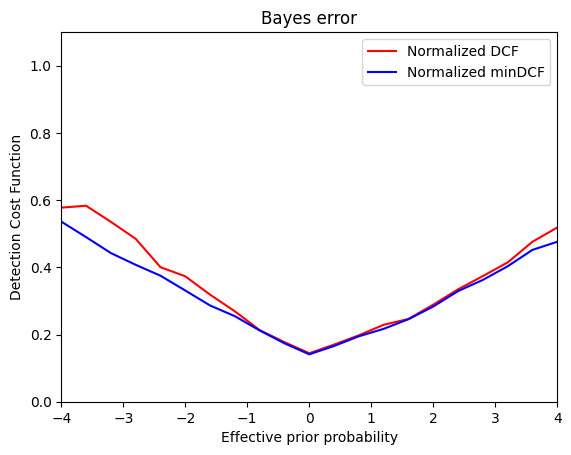

In [162]:
print(f"LR evaluation set calibrated with prior {prior}")
compute_statistics(lr_score_eval_calibrated, y_eval, prior, unique_labels=[0, 1], graph=True)

In [163]:
score_matrix = np.vstack([gmm_score, svm_score, lr_score])
clf_fusion = LogisticRegressionWeighted(lambda_=0, pi=prior_calibration, n_T=np.sum(y_test==1), n_F=np.sum(y_test==0))
clf_fusion.fit(score_matrix, y_test)

score_eval_matrix = np.vstack([gmm_score_eval, svm_score_eval, lr_score_eval])
fused_score_eval = clf_fusion.score(score_eval_matrix) - np.log(prior_calibration / (1 - prior_calibration))

Fusion evaluation set with prior 0.1
MinDCF: 0.1961, DCF: 0.0214, Normalized DCF: 0.2137, Accuracy: 93.67%



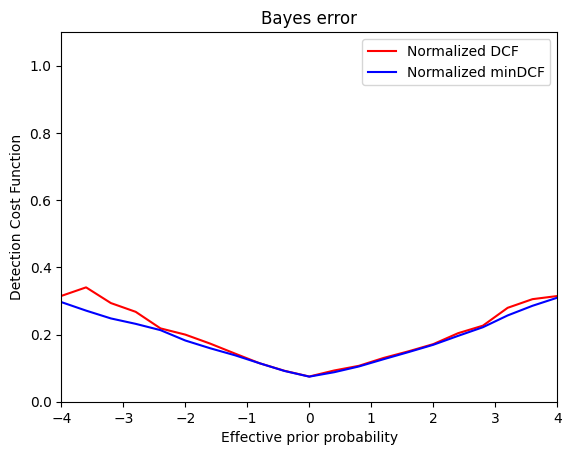

In [164]:
print(f"Fusion evaluation set with prior {prior}")
compute_statistics(fused_score_eval, y_eval, prior, unique_labels=[0, 1], graph=True)

#### Test to see if training strategies are effective

In [165]:
# dict for storing the minDCF, DCF and DCF_norm for each model
models_performances = {}

In [166]:
def compute_statistics_gmm(llr, y_true, prior, unique_labels=None):
    cost_matrix, prior_class_prob, threshold = binary_cost_matrix(prior)
    
    min_DCF, best_threshold = compute_minDCF(llr, y_true, prior, unique_labels)
    y_pred = (llr > threshold) * 1
    y_pred_best = (llr > best_threshold) * 1
    cm = confusion_matrix(y_true, y_pred, unique_labels)
    cm_best = confusion_matrix(y_true, y_pred_best, unique_labels)
    acc = accuracy(cm_best)
    DCF, _, _ = compute_DCF(cm, cost_matrix, prior_class_prob)
    DCF_norm, _, _ = compute_DCF_normalized(cm, cost_matrix, prior_class_prob)
    
    # print(f"MinDCF: {min_DCF:.4f}, DCF: {DCF:.4f}, Normalized DCF: {DCF_norm:.4f}, Accuracy: {acc*100:.2f}%\n")
    
    return min_DCF, DCF, DCF_norm

Full

In [167]:
n_components = [1, 2, 4, 8, 16, 32]
psiEig = 0.01

In [168]:
covariance_type = 'full'

min_DCF_list_full = []
DCF_norm_list_full = []

for n in n_components:
    print(f"Number of components: {n}")
    model = GMM(n_components=n, covariance_type=covariance_type, psiEig=psiEig)
    folder = f"gmm_eval_set_{covariance_type}_{n}_components"
    model.fit(X_train, y_train, n_features=2, folder=folder, test_only=test_only)
    score = model.score_binary(X_eval)
    min_DCF, DCF, DCF_norm = compute_statistics_gmm(score, y_eval, prior=0.1, unique_labels=[0, 1])
    min_DCF_list_full.append(min_DCF)
    DCF_norm_list_full.append(DCF_norm)
    models_performances[folder] = {'minDCF': min_DCF, 'DCF': DCF, 'DCF_norm': DCF_norm}

Number of components: 1
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 2
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 4
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 8
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 16
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 32
GMM 0 loaded successfully.
GMM 1 loaded successfully.


In [169]:
covariance_type = 'diagonal'

min_DCF_list_full = []
DCF_norm_list_full = []

for n in n_components:
    print(f"Number of components: {n}")
    model = GMM(n_components=n, covariance_type=covariance_type, psiEig=psiEig)
    folder = f"gmm_eval_set_{covariance_type}_{n}_components"
    model.fit(X_train, y_train, n_features=2, folder=folder, test_only=test_only)
    score = model.score_binary(X_eval)
    min_DCF, DCF, DCF_norm = compute_statistics_gmm(score, y_eval, prior=0.1, unique_labels=[0, 1])
    min_DCF_list_full.append(min_DCF)
    DCF_norm_list_full.append(DCF_norm)
    models_performances[folder] = {'minDCF': min_DCF, 'DCF': DCF, 'DCF_norm': DCF_norm}

Number of components: 1
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 2
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 4
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 8
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 16
GMM 0 loaded successfully.
GMM 1 loaded successfully.
Number of components: 32
GMM 0 loaded successfully.
GMM 1 loaded successfully.


In [170]:
for model in models_performances:
    print(f"{model}: {models_performances[model]}")

gmm_eval_set_full_1_components: {'minDCF': 0.40726674740830454, 'DCF': 0.04333681485349837, 'DCF_norm': 0.4333681485349837}
gmm_eval_set_full_2_components: {'minDCF': 0.2968188535428171, 'DCF': 0.030319336881520907, 'DCF_norm': 0.30319336881520903}
gmm_eval_set_full_4_components: {'minDCF': 0.246202735585951, 'DCF': 0.025513283480927566, 'DCF_norm': 0.2551328348092756}
gmm_eval_set_full_8_components: {'minDCF': 0.1801820020222447, 'DCF': 0.019371437460416228, 'DCF_norm': 0.19371437460416227}
gmm_eval_set_full_16_components: {'minDCF': 0.2024500272225247, 'DCF': 0.0206343403815598, 'DCF_norm': 0.206343403815598}
gmm_eval_set_full_32_components: {'minDCF': 0.2294403271147457, 'DCF': 0.024429049211657908, 'DCF_norm': 0.24429049211657908}
gmm_eval_set_diagonal_1_components: {'minDCF': 0.4097678863098479, 'DCF': 0.043006366737408194, 'DCF_norm': 0.4300636673740819}
gmm_eval_set_diagonal_2_components: {'minDCF': 0.3657151746130513, 'DCF': 0.037230413671263014, 'DCF_norm': 0.37230413671263013

In [171]:
# find the model with the lowest minDCF
minDCF = np.inf
best_model = None
for model, performance in models_performances.items():
    if performance['minDCF'] < minDCF:
        minDCF = performance['minDCF']
        DCF_norm = performance['DCF_norm']
        best_model = model
    # print(f"{model}: MinDCF: {performance['minDCF']:.4f}, DCF: {performance['DCF']:.4f}, Normalized DCF: {performance['DCF_norm']:.4f}")

print(f"Best model: {best_model}, MinDCF: {minDCF:.4f}, DCF: {DCF_norm:.4f}")

Best model: gmm_eval_set_full_8_components, MinDCF: 0.1802, DCF: 0.1937


Number of components: 8
GMM 0 loaded successfully.
GMM 1 loaded successfully.
MinDCF: 0.1802, DCF: 0.0194, Normalized DCF: 0.1937, Accuracy: 93.80%



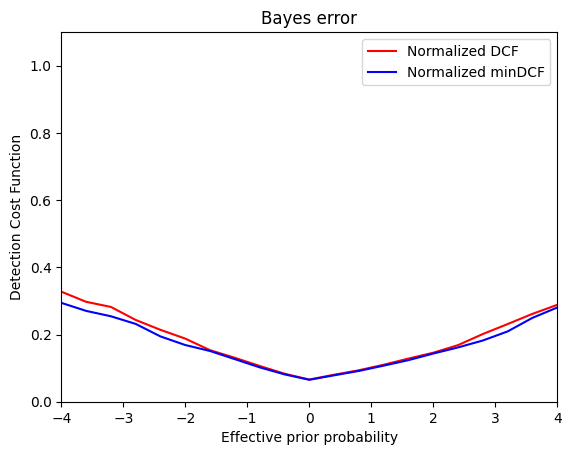

In [172]:
covariance_type = 'full'
n = 8

print(f"Number of components: {n}")
model = GMM(n_components=n, covariance_type=covariance_type, psiEig=psiEig)
folder = f"gmm_eval_set_{covariance_type}_{n}_components"
model.fit(X_train, y_train, n_features=2, folder=folder, test_only=test_only)
score = model.score_binary(X_eval)
compute_statistics(score, y_eval, prior=0.1, unique_labels=[0, 1], graph=True)